# Spam Email Detection Using Hybrid LSTM-CNN Model

## Abstract

This study investigates the implementation of a hybrid deep learning model combining Long Short-Term Memory (LSTM) and Convolutional Neural Networks (CNN) for spam email detection. The hybrid approach leverages the sequential processing strength of LSTM to capture temporal patterns in text data and the feature extraction efficiency of CNN to identify local patterns such as keywords or phrases. The model achieved high accuracy, precision, and recall, demonstrating its effectiveness in classifying email content into spam and non-spam categories. This work highlights the potential of hybrid architectures in solving real-world spam detection challenges while offering scalability and robust performance for practical applications.



## Introduction

Spam emails are a significant challenge, affecting cybersecurity and productivity. Traditional machine learning models can work but often require manual feature engineering and struggle to handle complex text patterns. Deep learning models, however, excel by automatically extracting these patterns.

This study uses a hybrid LSTM-CNN model to detect spam emails. The **LSTM** captures the sequence of words, while the **CNN** identifies important features in the text. Together, these methods improve classification accuracy and make the model effective for real-world use.


## Dataset Overview

The dataset contains email messages labeled as spam or non-spam. The features include:

- `v1`: Label (ham for non-spam, spam for spam emails).
- `v2`: Email content as text data.

Other columns in the raw dataset are irrelevant or contain missing data (`NaN`) and have been dropped during preprocessing.

### Sample Data
Below are the first five rows of the cleaned dataset:
- **v1 (Label)**: Indicates whether the email is spam or ham.
- **v2 (Email Content)**: The text of the email.


In [67]:
import pandas as pd

# Load dataset (update path to match your Kaggle dataset location)
dataset = pd.read_csv('spam.csv', encoding='latin1')

# Drop irrelevant columns
dataset = dataset[['v1', 'v2']]

# Check for missing values
print("Missing values per column:")
print(dataset.isnull().sum())

# Display the first few rows of the cleaned dataset
dataset.head()


Missing values per column:
v1    0
v2    0
dtype: int64


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

The dataset is analyzed to understand the following key characteristics:

### 1. Class Distribution
A bar chart shows the distribution of email types in the dataset:
- **Ham (Non-Spam)**: Majority class, with significantly more samples compared to spam.
- **Spam**: Minority class, highlighting a class imbalance that could impact model performance. Techniques like class weighting or oversampling may be required to handle this imbalance.

### 2. Text Length Distribution
The distribution of text lengths across email types reveals:
- **Ham Emails**: Typically shorter in length.
- **Spam Emails**: Slightly longer, possibly due to the inclusion of promotional details or keywords.

Understanding text length distribution helps in setting appropriate padding/truncation limits for preprocessing.

### 3. Word Cloud Visualization
Word clouds are generated for spam and non-spam emails to show frequently occurring words, giving insight into common terms used in each class. For instance:
- **Spam Emails**: Words like "claim," "free," "urgent" frequently occur.
- **Non-Spam Emails**: Words like "ok," "will," "come" are common.


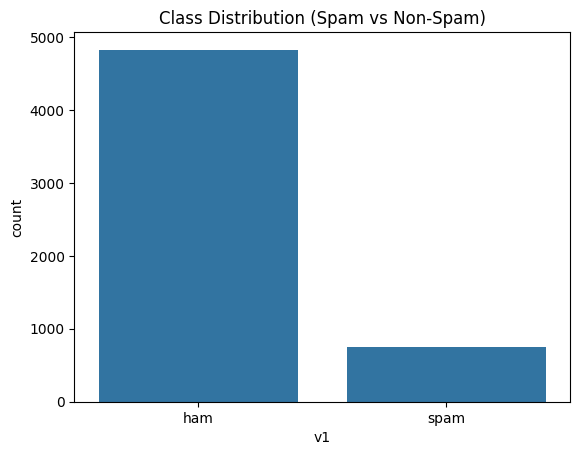

Class Distribution Counts:
v1
ham     4825
spam     747
Name: count, dtype: int64


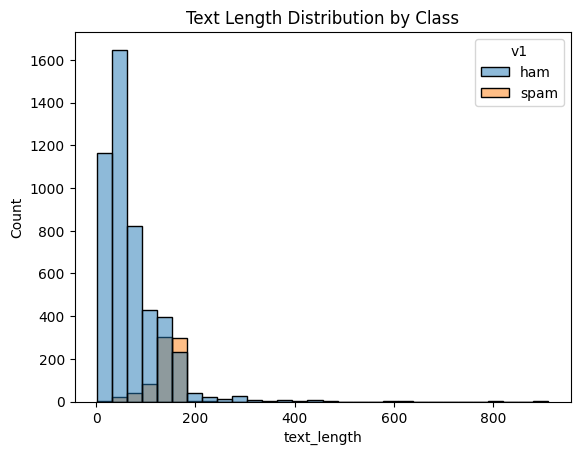

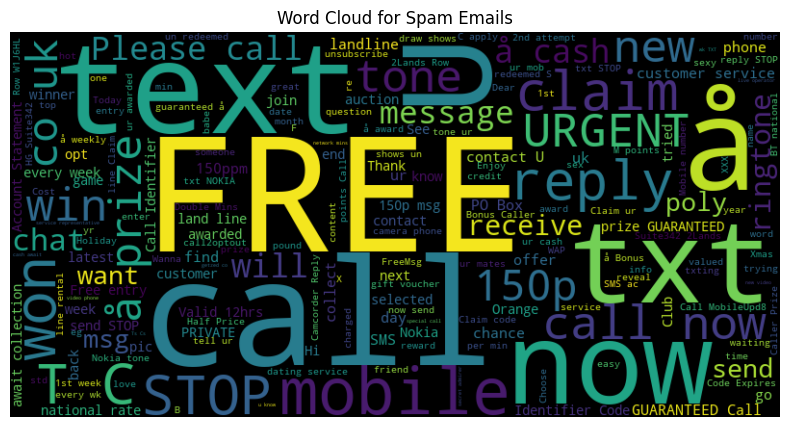

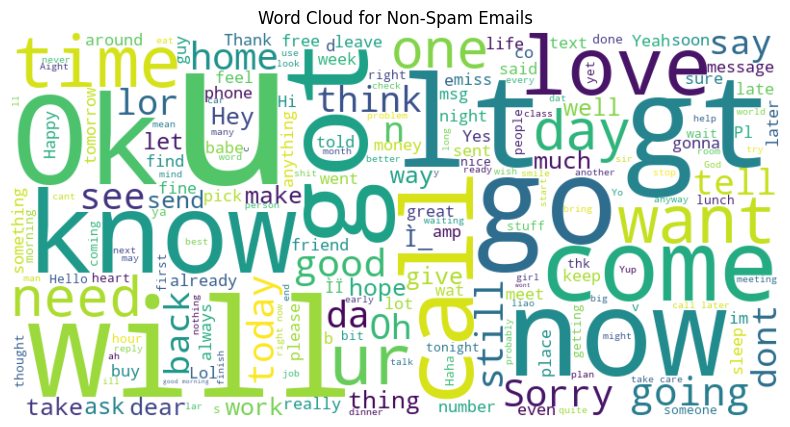

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Visualize class distribution
sns.countplot(x='v1', data=dataset)
plt.title('Class Distribution (Spam vs Non-Spam)')
plt.show()

# Numerical count of classes
class_counts = dataset['v1'].value_counts()
print("Class Distribution Counts:")
print(class_counts)

# Analyze text length
dataset['text_length'] = dataset['v2'].apply(len)
sns.histplot(data=dataset, x='text_length', hue='v1', bins=30)
plt.title('Text Length Distribution by Class')
plt.show()

# Function to generate word clouds
def generate_word_cloud(text, title, background_color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word clouds for spam and ham
spam_text = " ".join(dataset[dataset['v1'] == 'spam']['v2'])
ham_text = " ".join(dataset[dataset['v1'] == 'ham']['v2'])

generate_word_cloud(spam_text, "Word Cloud for Spam Emails", background_color='black')
generate_word_cloud(ham_text, "Word Cloud for Non-Spam Emails")


## Data Preprocessing

To prepare the dataset for modeling, the following steps were performed:

### 1. Label Encoding
- The target variable (`v1`) was mapped to binary values:
  - `ham`: 0 (non-spam)
  - `spam`: 1 (spam)

### 2. Text Tokenization and Cleaning
- Punctuation and stopwords were removed to clean the text data, making it more suitable for model input.
- The `Tokenizer` from TensorFlow was used to convert email text into sequences of integers.
- Words not found in the training vocabulary were replaced with a special `<OOV>` token.
- A vocabulary size of 5000 words was set to ensure efficient processing.

### 3. Sequence Padding
- All sequences were padded to a maximum length of 100 to ensure uniform input dimensions.

### 4. Train-Test Split
- The dataset was split into training and testing subsets:
  - **Training Data**: 80%
  - **Testing Data**: 20%
- A random state of 42 was used to maintain reproducibility.



In [69]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Label encoding
dataset['label'] = dataset['v1'].map({'ham': 0, 'spam': 1})

# Text cleaning: remove punctuation and stopwords
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

dataset['v2'] = dataset['v2'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['v2'])
sequences = tokenizer.texts_to_sequences(dataset['v2'])

# Padding
padded_sequences = pad_sequences(sequences, maxlen=100)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, dataset['label'], test_size=0.2, random_state=42
)


## Hybrid Model Architecture

This section describes the architecture of the hybrid deep learning model, which combines LSTM and CNN layers for spam email detection.

### Key Layers:
1. **Embedding Layer**:
   - Converts words into dense vector representations, capturing semantic relationships between words.
2. **LSTM Layer**:
   - Extracts sequential patterns and temporal dependencies from the text data.
   - Essential for understanding the order and context of words.
3. **CNN Layer**:
   - Identifies local patterns in the LSTM output, such as n-grams or key phrases.
   - Includes a MaxPooling layer to reduce dimensionality and focus on the most important features.
4. **Dense Layers**:
   - Integrates learned features for binary classification.
5. **Dropout Layers**:
   - Regularizes the model by randomly disabling a fraction of neurons during training, reducing the risk of overfitting.

### Model Summary:
- **Total Parameters**: 902,593
- **Trainable Parameters**: 902,593
- **Non-Trainable Parameters**: 0
- The architecture is compact, making it efficient for training while achieving high performance.


In [70]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten

# Define the model
model = Sequential([
    # Embedding layer for word vector representations
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    
    # LSTM layer to capture sequential dependencies
    LSTM(64, return_sequences=True),
    
    # Dropout for regularization
    Dropout(0.2),
    
    # 1D Convolutional layer for local feature extraction
    Conv1D(64, kernel_size=3, activation='relu'),
    
    # MaxPooling layer to reduce dimensionality
    MaxPooling1D(pool_size=2),
    
    # Flattening layer to convert 2D outputs to 1D
    Flatten(),
    
    # Dense layer with ReLU activation for feature integration
    Dense(64, activation='relu'),
    
    # Dropout for regularization
    Dropout(0.5),
    
    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.build(input_shape=(None, 100))  # Input shape matches padding length
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


c:\Users\abdullah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 98, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 902,593 (3.44 MB)

 Trainable params: 902,593 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

The model was trained using the following settings:
- **Epochs**: 10
- **Batch Size**: 32
- **Validation Split**: 20% of training data was reserved for validation.

### Learning Curves
Plots of training and validation accuracy/loss provide insights into model performance:
- **Training vs Validation Accuracy**:
  - Illustrates how well the model fits the training and validation datasets.
  - A large gap between curves may indicate overfitting.
- **Training vs Validation Loss**:
  - Tracks how well the model minimizes errors during training and validation.

The learning curves suggest strong convergence, with near-perfect accuracy on the training set and high accuracy on the validation set. Minor fluctuations in validation accuracy and loss may indicate mild overfitting.


Epoch 1/10
112/112 - 5s - 40ms/step - accuracy: 0.9088 - loss: 0.2298 - val_accuracy: 0.9731 - val_loss: 0.0896
Epoch 2/10
112/112 - 2s - 21ms/step - accuracy: 0.9860 - loss: 0.0596 - val_accuracy: 0.9787 - val_loss: 0.0778
Epoch 3/10
112/112 - 2s - 21ms/step - accuracy: 0.9944 - loss: 0.0284 - val_accuracy: 0.9798 - val_loss: 0.1352
Epoch 4/10
112/112 - 2s - 21ms/step - accuracy: 0.9975 - loss: 0.0166 - val_accuracy: 0.9787 - val_loss: 0.1369
Epoch 5/10
112/112 - 2s - 21ms/step - accuracy: 0.9966 - loss: 0.0375 - val_accuracy: 0.9821 - val_loss: 0.0701
Epoch 6/10
112/112 - 2s - 20ms/step - accuracy: 0.9972 - loss: 0.0108 - val_accuracy: 0.9664 - val_loss: 0.1435
Epoch 7/10
112/112 - 2s - 20ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9742 - val_loss: 0.1260
Epoch 8/10
112/112 - 2s - 21ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9798 - val_loss: 0.1441


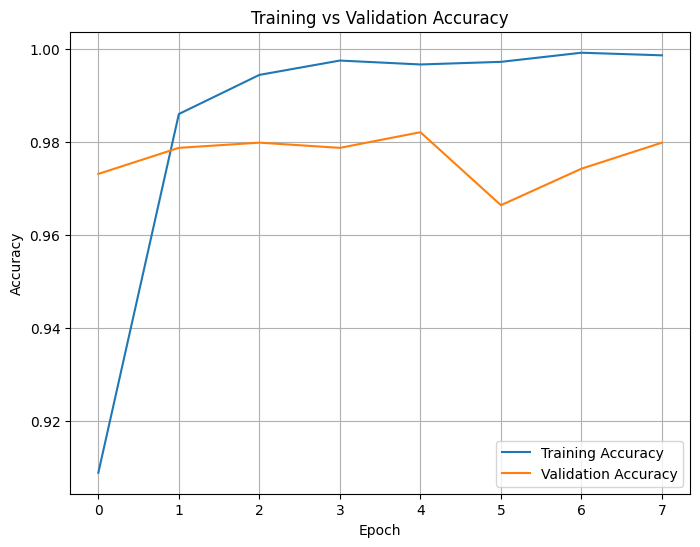

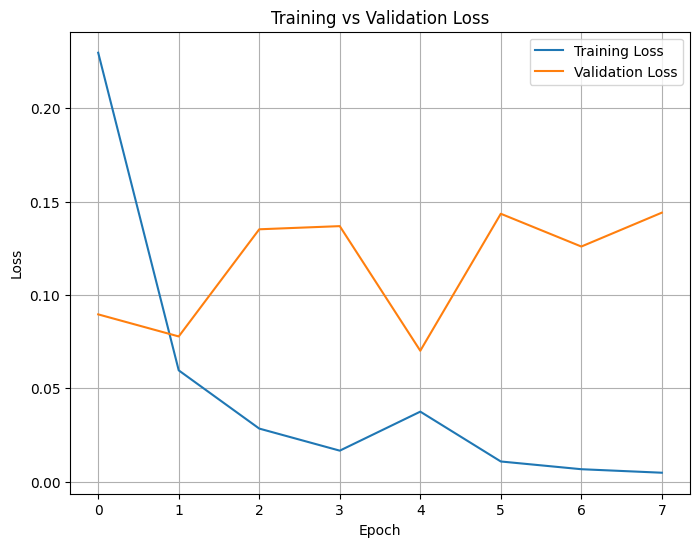

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=2,
    callbacks=[early_stopping]
)

# Plot learning curves
# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Model Evaluation

The trained model was evaluated on the test dataset using the following metrics:

1. **Accuracy**: Measures the overall correctness of the model's predictions.
2. **Precision, Recall, and F1-Score**: Provides insights into the model's performance on both spam and non-spam classes.
3. **Confusion Matrix**: Visualizes the counts of correct and incorrect classifications for each class.
4. **ROC Curve**: Highlights the model's ability to distinguish between the classes with the AUC score.
5. **Precision-Recall Curve**: Emphasizes performance on the minority class (spam), particularly useful for imbalanced datasets.

### Visualizations:
- **Confusion Matrix**: Shows the counts of True Positives, True Negatives, False Positives, and False Negatives.
- **ROC Curve**: Displays the tradeoff between sensitivity and specificity.
- **Precision-Recall Curve**: Illustrates the balance between precision and recall for varying thresholds.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.95      0.92      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



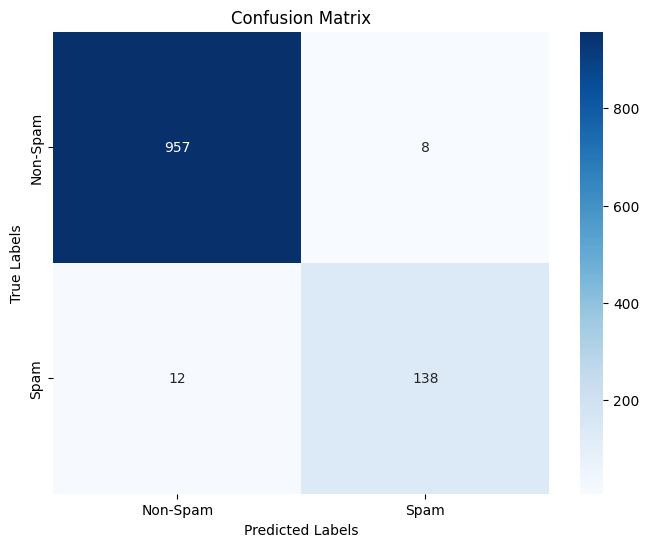

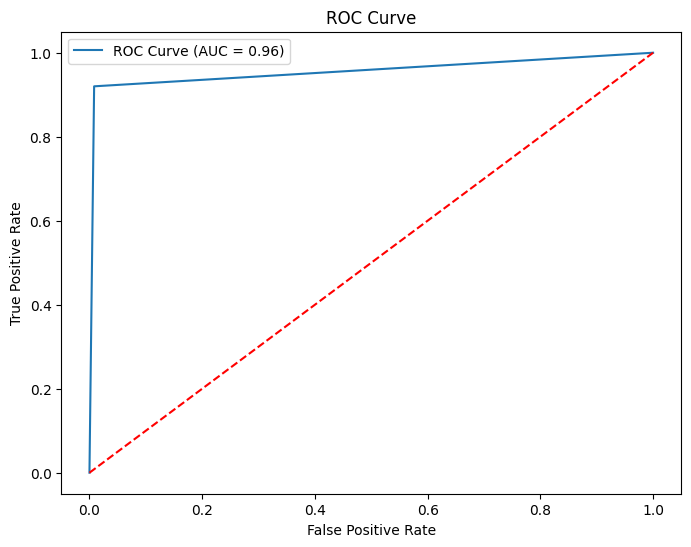

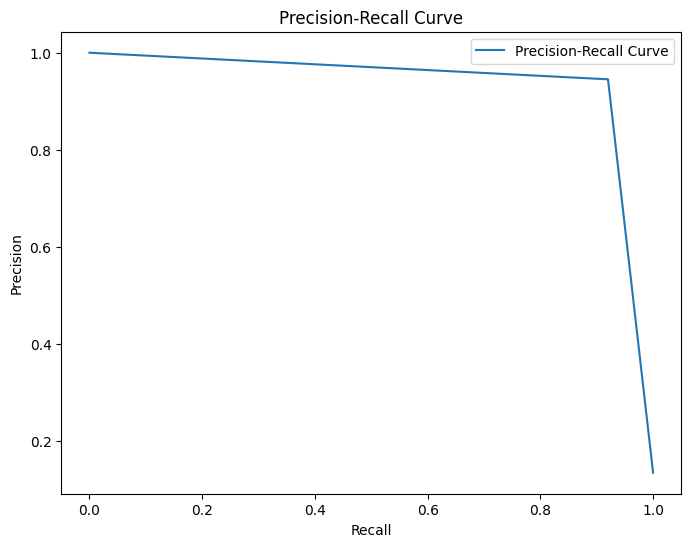

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Binary classification

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute and plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')  # Random model line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Compute and plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


## Conclusion

The hybrid LSTM-CNN model developed in this study for spam email detection achieved exceptional performance across multiple evaluation metrics. The key outcomes are:

- **Accuracy**: The model demonstrated a high test accuracy of **98%**, indicating its robustness in distinguishing between spam and non-spam emails.
- **Precision and Recall**: With a precision of **95%** and a recall of **92%** for spam detection, the model effectively minimizes false positives while ensuring most spam emails are correctly classified.
- **F1-Score**: A high F1-score of **93%** for the spam class highlights the model's balance between precision and recall, critical for practical spam detection systems.
- **ROC-AUC**: The model achieved an impressive AUC of **0.96**, reflecting its excellent discriminatory power.
- **Confusion Matrix**: The confusion matrix revealed minimal misclassification, with **138 spam emails correctly classified out of 150** and only **12 false negatives**.
- **Learning Curves**: The training and validation curves illustrate stable training with minimal overfitting, supported by consistently low validation loss.

Despite the significant class imbalance in the dataset, the model maintained high performance without the need for explicit oversampling techniques. However, the dataset's imbalance could still impact recall for the minority class (spam). Future enhancements could include:
- Incorporating **data augmentation** techniques or synthetic oversampling to further improve recall for spam emails.
- Exploring advanced architectures like **attention mechanisms** to capture nuanced patterns in text data.
- Leveraging larger and more diverse datasets to improve generalizability.

This study demonstrates the potential of hybrid deep learning models in solving spam detection challenges, providing a scalable solution for real-world applications.


# Reference

Dataset Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

# -----------------------------------------------------